## Environment Setup

In [27]:
from IPython.display import clear_output
clear_output()

In [28]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.svm import SVC, LinearSVC
import tensorflow as tf


import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, Adamax
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping
from keras import layers

sns.set_style("darkgrid")

init_notebook_mode(connected=True)
RANDOM_SEED = 123

## Split Train/Test/Val

In [29]:
# os.makedirs(os.getcwd()+"\\brain_tumor_dataset", exist_ok=True)

IMG_PATH = os.getcwd()+"\\brain_tumor_dataset"
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + '\\' + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH +'\\'+ CLASS)):
            img = IMG_PATH + '\\' + CLASS + '\\' + FILE_NAME
            if n < 5:
                shutil.copy(img, os.getcwd() + '\\TEST\\' + CLASS.upper() + '\\' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, os.getcwd() + '\\TRAIN\\' + CLASS.upper() + '\\' + FILE_NAME)
            else:
                shutil.copy(img, os.getcwd() + '\\VAL\\' + CLASS.upper() + '\\' + FILE_NAME)

## Data Import

In [30]:
# load the data as np arrays and resize
def load_data(dir_path, img_size=(100,100)):
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [31]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00,  6.74it/s]
C:\Users\Harle\AppData\Local\Temp/ipykernel_28848/3893878741.py:16: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



193 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00, 181.82it/s]


10 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:00<00:00, 22.40it/s]

50 images loaded from VAL/ directory.


In [32]:
# count samples in each dataset
print(" Train NO: ", (y_train == 0).sum())
print(" Train YES: ", (y_train == 1).sum())
print(" Val NO: ", (y_val == 0).sum())
print(" Val YES: ", (y_val == 1).sum())
print(" Test NO: ", (y_test == 0).sum())
print(" Test YES: ", (y_test == 1).sum())

 Train NO:  74
 Train YES:  119
 Val NO:  19
 Val YES:  31
 Test NO:  5
 Test YES:  5


## Distribution of Classes

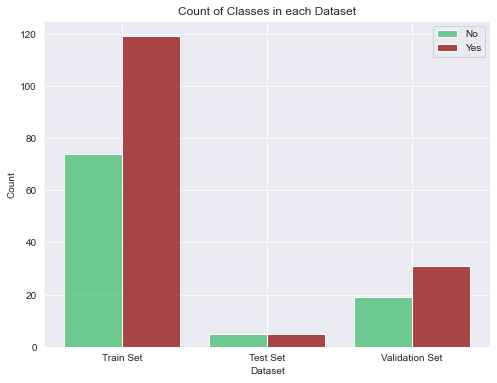

In [33]:
y = dict()
y[0] = []
y[1] = []

for set_name in (y_train, y_test, y_val):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

X = ['Train Set', 'Test Set', 'Validation Set']
X_axis = np.arange(len(X))

plt.figure(figsize=(8,6))  
plt.bar(X_axis - 0.2, y[0], 0.4, label = 'No', color=(0.1,0.7,0.3,0.6))
plt.bar(X_axis + 0.2, y[1], 0.4, label = 'Yes' ,color=(0.6,0.1,0.1,0.8))
  
plt.xticks(X_axis, X)
plt.xlabel("Dataset")
plt.ylabel("Count")
plt.title("Count of Classes in each Dataset")
plt.legend()
plt.show()

## Plotting

In [34]:
# plot samples from each class
def plot_samples(X, y, labels_dict, n=50):

    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10 
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1

        for img in imgs:
            plt.subplot(i, j, c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1 
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

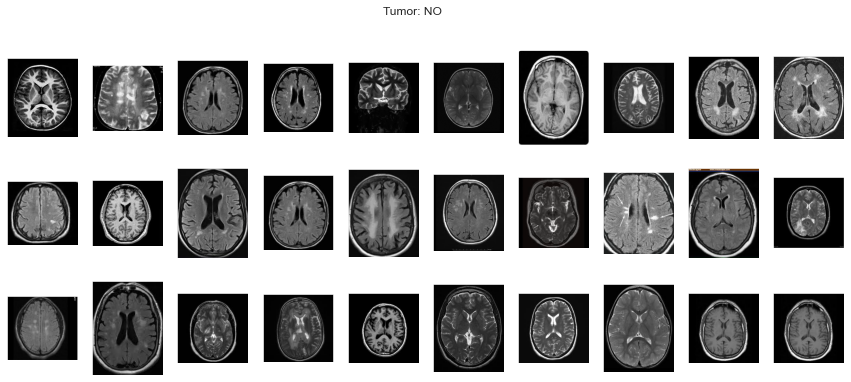

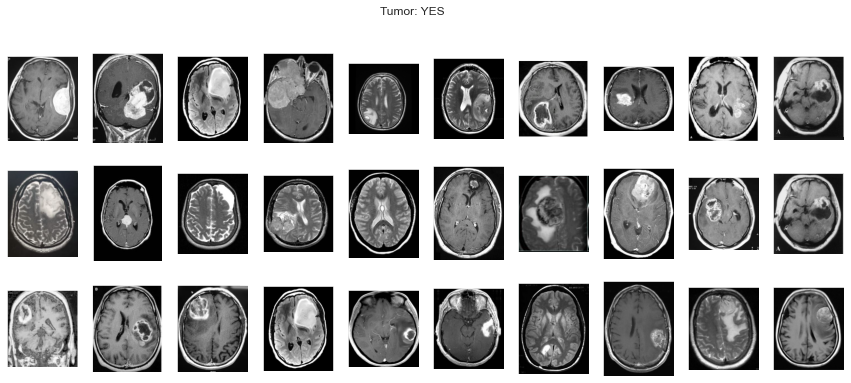

In [35]:
plot_samples(X_train, y_train, labels, 30)

## Checking Image Ratios

As we can see the images of are different size (width and height) and different whitespace corners. Since most pretrained CNN models require an input size of 244x244, the images will need to be resized. Here we plot histograms of the image ratios as a histogram distribution (ratio = width/height).

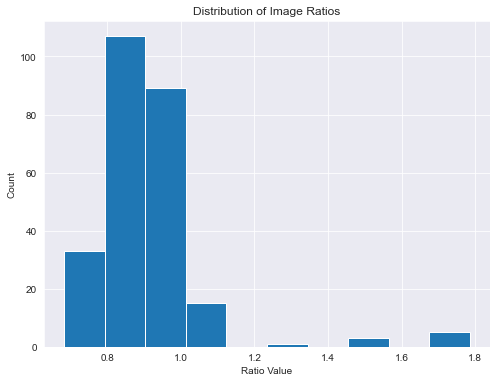

In [36]:
RATIOS = []

for set in (X_train, X_test, X_val):
    for img in set:
        RATIOS.append(img.shape[1]/img.shape[0])

plt.figure(figsize=(8,6))
plt.hist(RATIOS)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

## Normalization - Cropping

The first step of "normalization" would be to crop the brain out of the images. This technique was used from pyimagesearch at https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/.

In [37]:
# function to perform Morphological Operations, find extreme points, contouring and cropping the images
def crop_imgs(set_name, add_pixel_values=0):
    set_new = []
    for img in set_name:
        # grayscale the images
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # image smoothing (to reduce the noise and sharpen the edges)
        gray = cv2.GaussianBlur(gray, (5,5), 0)

        # threshold the image (binarization) then perform series of erosions and dilations
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in the thresholded images and extract the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        # add contour on the image
        img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

        # add extreme points
        img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
        img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
        img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
        img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

        # crop using the extreme points
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)
        
    return np.array(set_new)

Here we will look at an example for what this function will do to an image and plot each step.

In [38]:
path = os.getcwd() + '\\TRAIN\\NO\\'
preview_img_path = path + os.listdir(path)[5]
img = cv2.imread(preview_img_path)
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

Text(0.5, 1.0, 'Cropped Image')

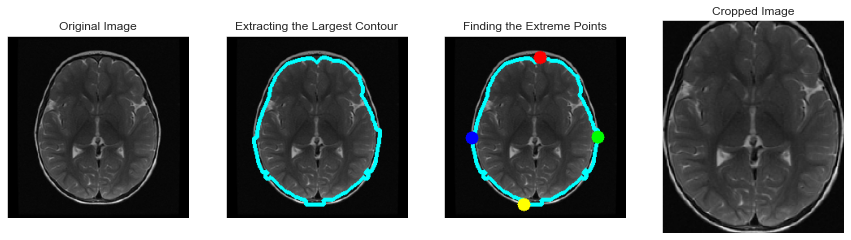

In [39]:
# plotting the different stages of the example image
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title("Original Image")
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title("Extracting the Largest Contour")
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title("Finding the Extreme Points")
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title("Cropped Image")

In [40]:
# apply this function for each dataset
X_train_crop = crop_imgs(set_name=X_train)
X_test_crop = crop_imgs(set_name=X_test)
X_val_crop = crop_imgs(set_name=X_val)

C:\Users\Harle\AppData\Local\Temp/ipykernel_28848/4254968841.py:40: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



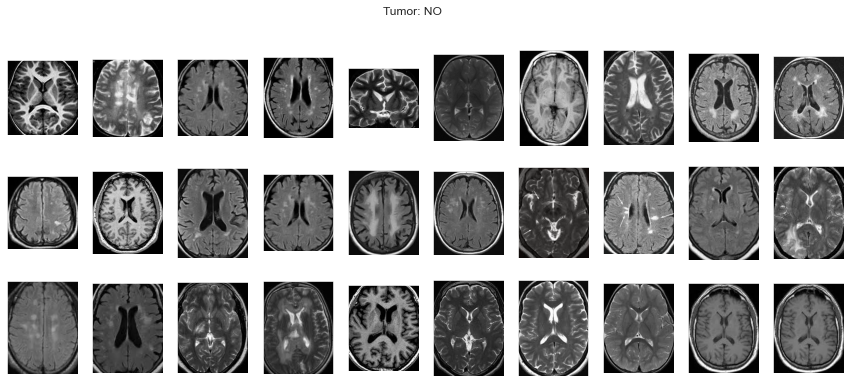

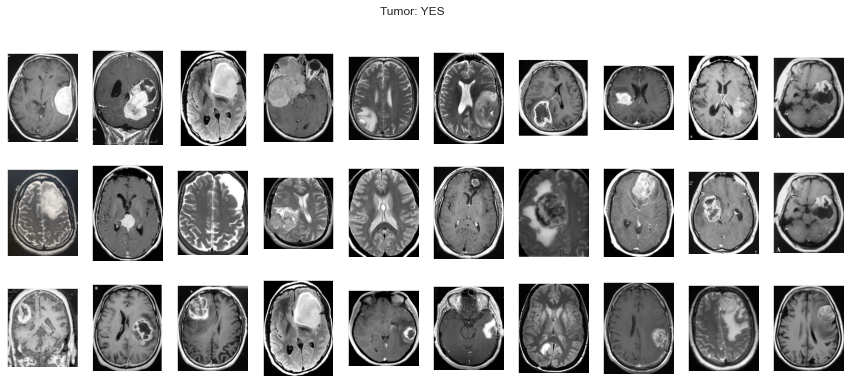

In [41]:
plot_samples(X_train_crop, y_train, labels, 30)

In [42]:
# function to save new images
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [43]:
# create folders for new cropped images
os.makedirs(os.getcwd()+"\\TRAIN_CROP\\YES", exist_ok=True)
os.makedirs(os.getcwd()+"\\TRAIN_CROP\\NO", exist_ok=True)
os.makedirs(os.getcwd()+"\\TEST_CROP\\YES", exist_ok=True)
os.makedirs(os.getcwd()+"\\TEST_CROP\\NO", exist_ok=True)
os.makedirs(os.getcwd()+"\\VAL_CROP\\YES", exist_ok=True)
os.makedirs(os.getcwd()+"\\VAL_CROP\\NO", exist_ok=True)

# saving new images to folder
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/' )
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')

## Normalization - Resizing

Next we need to resize the images to 224x224 and apply the preprocessing needed for the CNN models.

In [44]:
def preprocess_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [45]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

## Data Augmentation

### Demo Augmentation

Here we will take an example of an image and plot all the augmented images.

In [46]:
# parameters to change randomly for augmentation
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True)

In [47]:
# make directory for demo
os.makedirs('preview', exist_ok=True)

# take one example from training set
x = X_train_crop[8]
x = x.reshape((1,) + x.shape)

# load dataset from directory (flow is used for this)
i=0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

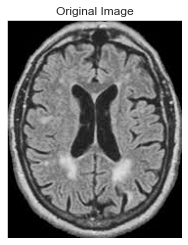

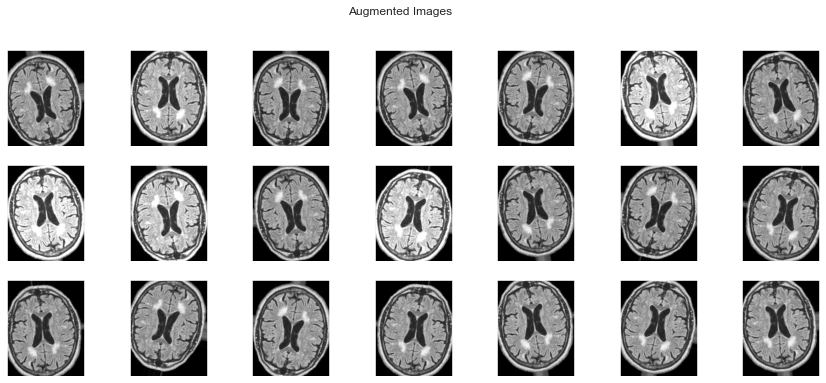

In [48]:
# plot original image
plt.imshow(X_train_crop[8])
plt.xticks([])
plt.yticks([])
plt.title("Original Image")

# plot augmented images
plt.figure(figsize=(15,6))

i = 1
for img in os.listdir('preview/'):
    img = cv2.imread('preview/'+ img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3 ,7 , i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break

plt.suptitle("Augmented Images")
plt.show()

### Apply Augmentation 

We use the `ImageDataGenerator` class from Keras to augment the images because it allows us to augment them in real-time as the model is training without storing the augmented images in the directory and wasting space. 

We apply this to all datasets.

In [49]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

# parameters to change randomly for augmentation and preprocess input
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

# preprocess input for testing
test_datagen = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

# load images from train directory to apply augmentations + input preprocessing
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)

# load images from validation directory to apply input preprocessing
validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


## CNN Model Building

In [50]:
# 4 layer CNN
NUM_CLASSES = 1
cnn_model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape = IMG_SIZE + (3,)),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
        MaxPool2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(NUM_CLASSES, activation='sigmoid')
])

cnn_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [52]:
EPOCHS = 30

history = cnn_model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2)

Epoch 1/30
7/7 - 5s - loss: 1.2150 - accuracy: 0.6062 - val_loss: 7.2773 - val_accuracy: 0.3800 - 5s/epoch - 708ms/step
Epoch 2/30
7/7 - 5s - loss: 1.1940 - accuracy: 0.6062 - val_loss: 0.8656 - val_accuracy: 0.5800 - 5s/epoch - 780ms/step
Epoch 3/30
7/7 - 5s - loss: 1.0263 - accuracy: 0.5751 - val_loss: 0.7531 - val_accuracy: 0.6200 - 5s/epoch - 715ms/step
Epoch 4/30
7/7 - 5s - loss: 1.0743 - accuracy: 0.6114 - val_loss: 0.6273 - val_accuracy: 0.6800 - 5s/epoch - 738ms/step
Epoch 5/30
7/7 - 6s - loss: 1.0474 - accuracy: 0.6062 - val_loss: 1.2640 - val_accuracy: 0.5400 - 6s/epoch - 914ms/step
Epoch 6/30
7/7 - 6s - loss: 1.0834 - accuracy: 0.5596 - val_loss: 0.9201 - val_accuracy: 0.6400 - 6s/epoch - 904ms/step
Epoch 7/30
7/7 - 6s - loss: 0.8046 - accuracy: 0.6062 - val_loss: 0.6137 - val_accuracy: 0.7000 - 6s/epoch - 858ms/step
Epoch 8/30
7/7 - 6s - loss: 1.1590 - accuracy: 0.6010 - val_loss: 0.9816 - val_accuracy: 0.6200 - 6s/epoch - 870ms/step
Epoch 9/30
7/7 - 6s - loss: 1.0029 - acc

### Model Performance


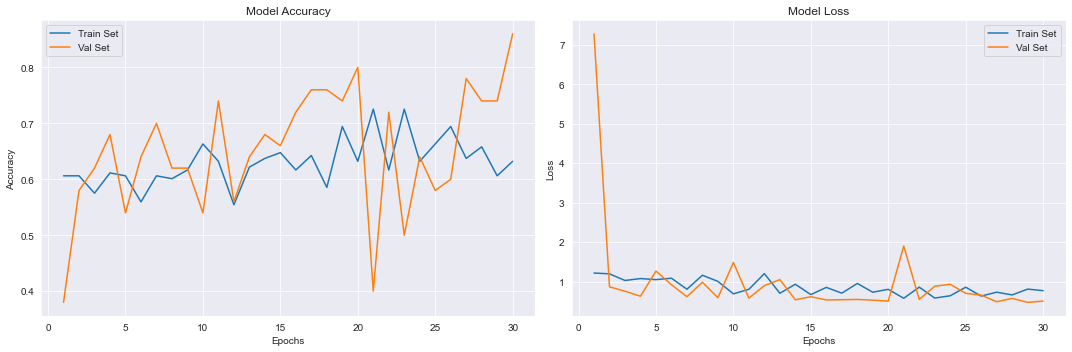

In [53]:
# function to plot model train/val accuracy
def plot_performance(model):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(history.epoch) + 1)

    plt.figure(figsize=(15,5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Set')
    plt.plot(epochs_range, val_acc, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Set')
    plt.plot(epochs_range, val_loss, label='Val Set')
    plt.legend(loc="best")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Model Loss')

    plt.tight_layout()
    plt.show()

plot_performance(cnn_model)

In [54]:
# function for confusion matrix and classification report
def model_evaluation(model, X, y):
    y_pred = model.predict(X)
    y_pred = np.array([1 if x>0.5 else 0 for x in y_pred])
    print("Classification Report")
    print(classification_report(y, y_pred))
    print("Confusion Matrix: ")
    sns.heatmap(confusion_matrix(y, y_pred), cmap='binary', cbar=True, annot=True, fmt='1', center=True)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.show()

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.47      0.60        19
           1       0.74      0.94      0.83        31

    accuracy                           0.76        50
   macro avg       0.78      0.70      0.71        50
weighted avg       0.77      0.76      0.74        50

Confusion Matrix: 


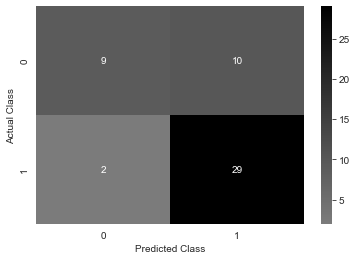

In [86]:
# validate on val set
model_evaluation(cnn_model, X_val_prep, y_val)

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.50      0.80      0.62         5

    accuracy                           0.50        10
   macro avg       0.50      0.50      0.45        10
weighted avg       0.50      0.50      0.45        10

Confusion Matrix: 


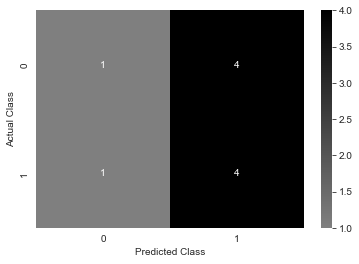

In [56]:
# validate on test set
model_evaluation(cnn_model, X_test_prep, y_test)

## VGG-16 Model Building

In [57]:
# load VGG model
vgg16_model = tf.keras.applications.vgg16.VGG16(include_top=False, input_shape=IMG_SIZE + (3,))
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [58]:
vgg_model = Sequential()
# add layers to sequential model
for layer in vgg16_model.layers:
    vgg_model.add(layer)

# layers in vgg should not be trainable
for layer in vgg_model.layers:
    layer.trainable = False

# flatten, dropout and FC layers
vgg_model.add(Flatten())
vgg_model.add(Dropout(0.2))
vgg_model.add(Dense(NUM_CLASSES, activation='sigmoid'))

vgg_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy']
)
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [59]:
EPOCHS = 30

history = vgg_model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2)

Epoch 1/30
7/7 - 25s - loss: 4.5244 - accuracy: 0.5233 - val_loss: 3.9785 - val_accuracy: 0.5400 - 25s/epoch - 4s/step
Epoch 2/30
7/7 - 27s - loss: 3.4463 - accuracy: 0.5699 - val_loss: 3.7432 - val_accuracy: 0.6600 - 27s/epoch - 4s/step
Epoch 3/30
7/7 - 27s - loss: 2.9184 - accuracy: 0.6684 - val_loss: 2.9684 - val_accuracy: 0.6400 - 27s/epoch - 4s/step
Epoch 4/30
7/7 - 30s - loss: 3.0097 - accuracy: 0.6684 - val_loss: 2.4005 - val_accuracy: 0.6800 - 30s/epoch - 4s/step
Epoch 5/30
7/7 - 34s - loss: 1.9011 - accuracy: 0.7254 - val_loss: 1.8879 - val_accuracy: 0.7600 - 34s/epoch - 5s/step
Epoch 6/30
7/7 - 37s - loss: 2.4308 - accuracy: 0.6943 - val_loss: 1.9495 - val_accuracy: 0.7800 - 37s/epoch - 5s/step
Epoch 7/30
7/7 - 31s - loss: 2.3562 - accuracy: 0.6891 - val_loss: 1.5045 - val_accuracy: 0.7400 - 31s/epoch - 4s/step
Epoch 8/30
7/7 - 28s - loss: 2.0203 - accuracy: 0.6995 - val_loss: 1.5271 - val_accuracy: 0.7400 - 28s/epoch - 4s/step
Epoch 9/30
7/7 - 28s - loss: 1.8124 - accuracy: 

### Model Performance

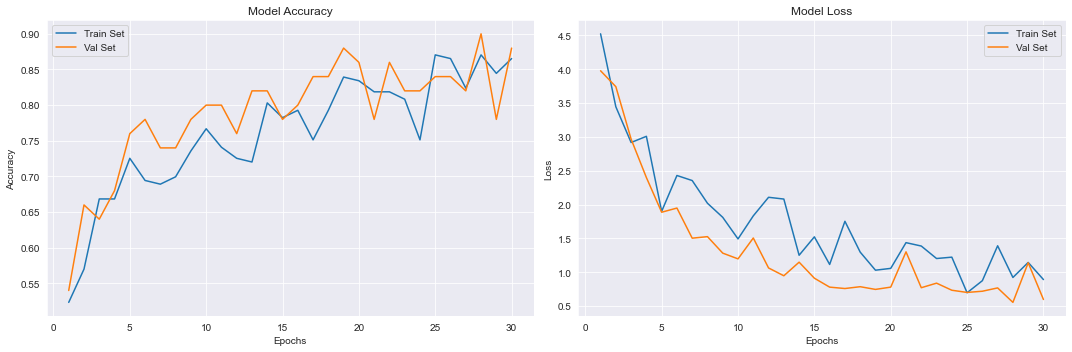

In [61]:
plot_performance(vgg_model)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        74
           1       0.94      0.97      0.95       119

    accuracy                           0.94       193
   macro avg       0.95      0.93      0.94       193
weighted avg       0.94      0.94      0.94       193

Confusion Matrix: 


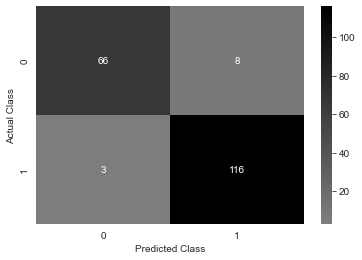

In [99]:
# validate on val set
model_evaluation(vgg_model, X_train_prep, y_train)  

AUC Score 0.9460028050490884


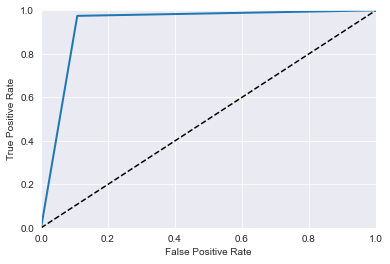

In [101]:
# plot ROC curve and AUC Score
def plot_roc_curve(model, X, y):
    y_pred = model.predict(X)
    y_pred = np.array([1 if x>0.5 else 0 for x in y_pred])
    print("AUC Score", roc_auc_score(y_pred, y))
    fpr, tpr, thresholds = roc_curve(y, y_pred)
    plt.plot(fpr, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(vgg_model, X_train_prep, y_train)

Classification Report
              precision    recall  f1-score   support

           0       0.83      1.00      0.91         5
           1       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

Confusion Matrix: 


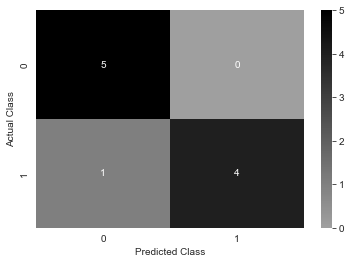

In [81]:
# validate on test set
model_evaluation(vgg_model, X_test_prep, y_test)

## InceptionV3 Model Building

In [82]:
#load InceptionV3 model
base_model = InceptionV3(input_shape = IMG_SIZE + (3,), include_top = False, weights = 'imagenet')

# layers should not be trainable
for layer in base_model.layers:
    layer.trainable = False

x = layers.Flatten()(base_model.output)
x = layers.Dropout(0.2)(x)
x = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

inception_model = tf.keras.models.Model(base_model.input, x)

inception_model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=['accuracy'])
    
inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d_4[0][0]']               
 alization)                     )                                                             

In [83]:
EPOCHS = 30

history = inception_model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2)

Epoch 1/30
7/7 - 9s - loss: 13.6010 - accuracy: 0.5544 - val_loss: 5.2125 - val_accuracy: 0.4600 - 9s/epoch - 1s/step
Epoch 2/30
7/7 - 6s - loss: 10.7245 - accuracy: 0.5544 - val_loss: 6.7392 - val_accuracy: 0.6000 - 6s/epoch - 911ms/step
Epoch 3/30
7/7 - 6s - loss: 6.6549 - accuracy: 0.6166 - val_loss: 2.4089 - val_accuracy: 0.7000 - 6s/epoch - 890ms/step
Epoch 4/30
7/7 - 7s - loss: 10.6765 - accuracy: 0.4767 - val_loss: 4.3967 - val_accuracy: 0.6200 - 7s/epoch - 972ms/step
Epoch 5/30
7/7 - 7s - loss: 5.6286 - accuracy: 0.6528 - val_loss: 3.2580 - val_accuracy: 0.6400 - 7s/epoch - 976ms/step
Epoch 6/30
7/7 - 7s - loss: 5.9945 - accuracy: 0.6010 - val_loss: 3.2630 - val_accuracy: 0.7000 - 7s/epoch - 944ms/step
Epoch 7/30
7/7 - 7s - loss: 9.2473 - accuracy: 0.6010 - val_loss: 3.2511 - val_accuracy: 0.6000 - 7s/epoch - 957ms/step
Epoch 8/30
7/7 - 7s - loss: 6.6986 - accuracy: 0.5648 - val_loss: 2.8991 - val_accuracy: 0.7000 - 7s/epoch - 960ms/step
Epoch 9/30
7/7 - 7s - loss: 7.9352 - acc

### Model Performance

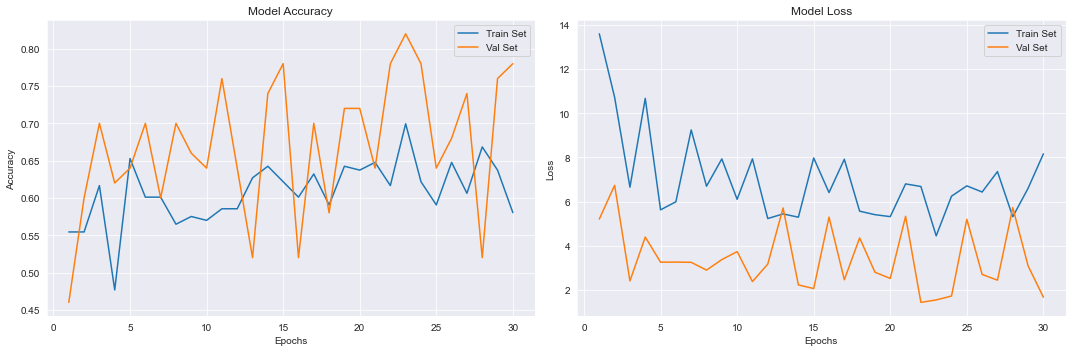

In [84]:
plot_performance(inception_model)

Classification Report
              precision    recall  f1-score   support

           0       0.59      0.84      0.69        74
           1       0.86      0.64      0.73       119

    accuracy                           0.72       193
   macro avg       0.73      0.74      0.71       193
weighted avg       0.76      0.72      0.72       193

Confusion Matrix: 


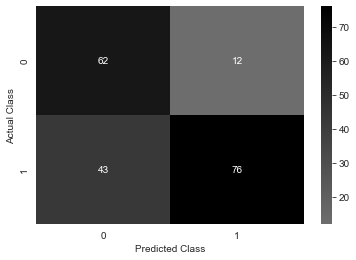

In [94]:
# validate on val set
model_evaluation(inception_model, X_train_prep, y_train)

Classification Report
              precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.67      0.80      0.73         5

    accuracy                           0.70        10
   macro avg       0.71      0.70      0.70        10
weighted avg       0.71      0.70      0.70        10

Confusion Matrix: 


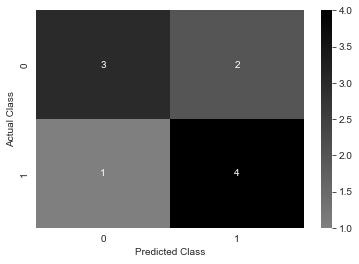

In [ ]:
# validate on test set
model_evaluation(inception_model, X_test_prep, y_test)

## ResNet50 Model Building

In [ ]:
# add ResNet50 model to sequential model
resnet_model = Sequential()
resnet_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))

# layers should not be trainable
for layer in resnet_model.layers:
    layer.trainable = False

resnet_model.add(Dropout(0.2))
resnet_model.add(Dense(NUM_CLASSES, activation='sigmoid'))

resnet_model.compile(#optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001), 
    optimizer= RMSprop(learning_rate=0.0001),
    loss = 'binary_crossentropy', 
    metrics = ['accuracy']
    )

resnet_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_10 (Dropout)        (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
EPOCHS = 10

history = resnet_model.fit(
    x=train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    verbose=2
)

Epoch 1/10
7/7 - 15s - loss: 3.7592 - accuracy: 0.4404 - val_loss: 2.0185 - val_accuracy: 0.5600 - 15s/epoch - 2s/step
Epoch 2/10
7/7 - 13s - loss: 2.6889 - accuracy: 0.5078 - val_loss: 1.4525 - val_accuracy: 0.6000 - 13s/epoch - 2s/step
Epoch 3/10
7/7 - 14s - loss: 2.5014 - accuracy: 0.5181 - val_loss: 1.4587 - val_accuracy: 0.5800 - 14s/epoch - 2s/step
Epoch 4/10
7/7 - 14s - loss: 2.3407 - accuracy: 0.5855 - val_loss: 1.4244 - val_accuracy: 0.5800 - 14s/epoch - 2s/step
Epoch 5/10
7/7 - 15s - loss: 2.4887 - accuracy: 0.5440 - val_loss: 1.2833 - val_accuracy: 0.5800 - 15s/epoch - 2s/step
Epoch 6/10
7/7 - 17s - loss: 2.4360 - accuracy: 0.5492 - val_loss: 1.2496 - val_accuracy: 0.5800 - 17s/epoch - 2s/step
Epoch 7/10
7/7 - 17s - loss: 2.4979 - accuracy: 0.5544 - val_loss: 1.2433 - val_accuracy: 0.6200 - 17s/epoch - 2s/step
Epoch 8/10
7/7 - 16s - loss: 2.0033 - accuracy: 0.6114 - val_loss: 1.1314 - val_accuracy: 0.5800 - 16s/epoch - 2s/step
Epoch 9/10
7/7 - 16s - loss: 1.9788 - accuracy: 

### Model Performance

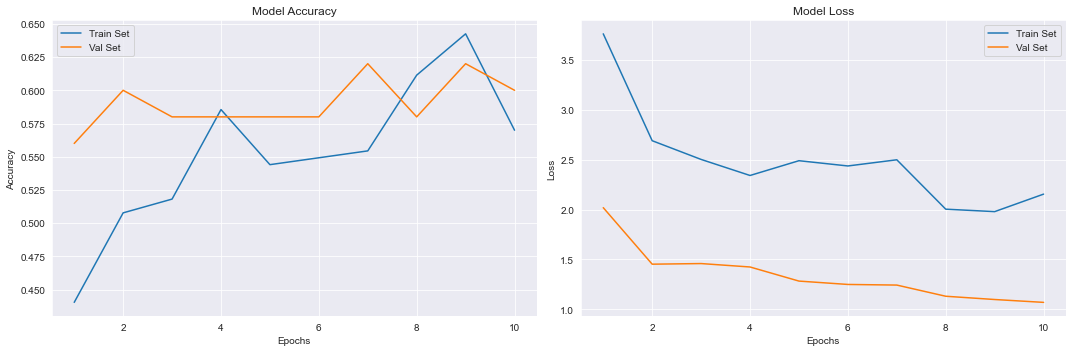

In [ ]:
plot_performance(resnet_model)

Classification Report
              precision    recall  f1-score   support

           0       0.43      0.47      0.45        19
           1       0.66      0.61      0.63        31

    accuracy                           0.56        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.57      0.56      0.56        50

Confusion Matrix: 


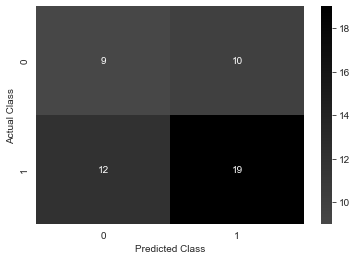

In [ ]:
# validate on val set
model_evaluation(resnet_model, X_val_prep, y_val)

Classification Report
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.40      0.40      0.40         5

    accuracy                           0.40        10
   macro avg       0.40      0.40      0.40        10
weighted avg       0.40      0.40      0.40        10

Confusion Matrix: 


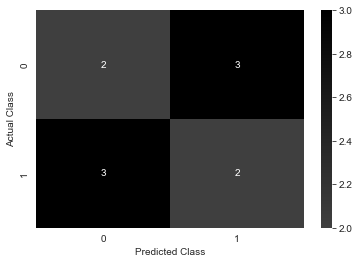

In [ ]:
# validate on test set
model_evaluation(resnet_model, X_test_prep, y_test)